In [113]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (18,6)


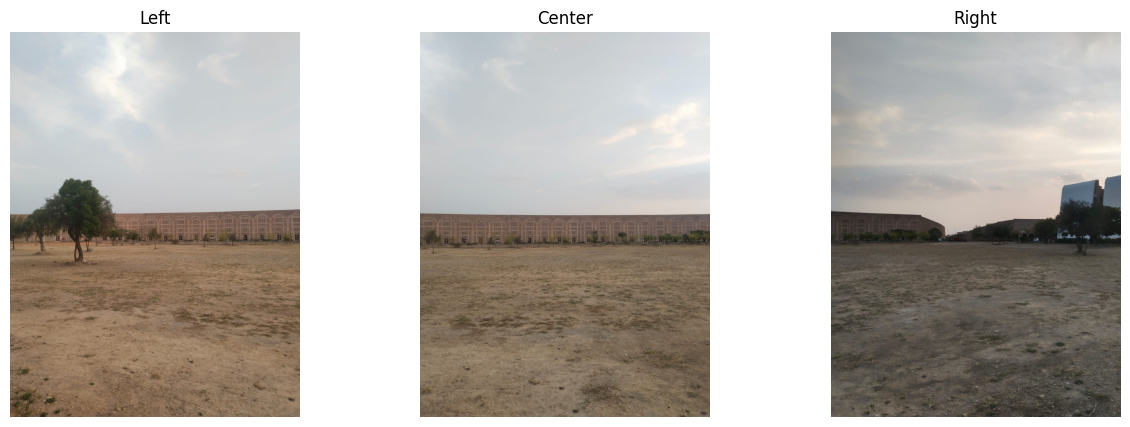

In [114]:
base_path = "images"

files = [f for f in os.listdir(base_path)
         if f.lower().endswith(('.jpg','.jpeg','.png'))]
files.sort()

if len(files) < 3:
    raise Exception("Need at least 3 images.")

img_left   = cv2.imread(os.path.join(base_path, files[0]))
img_center = cv2.imread(os.path.join(base_path, files[1]))
img_right  = cv2.imread(os.path.join(base_path, files[2]))

img_left   = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
img_right  = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img_left);   plt.title("Left");   plt.axis("off")
plt.subplot(1,3,2); plt.imshow(img_center); plt.title("Center"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(img_right);  plt.title("Right");  plt.axis("off")
plt.show()


In [115]:
gray_left   = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
gray_center = cv2.cvtColor(img_center, cv2.COLOR_RGB2GRAY)
gray_right  = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()

kp_left, des_left     = sift.detectAndCompute(gray_left, None)
kp_center, des_center = sift.detectAndCompute(gray_center, None)
kp_right, des_right   = sift.detectAndCompute(gray_right, None)

print("Keypoints:", len(kp_left), len(kp_center), len(kp_right))


Keypoints: 4543 3433 2544


In [116]:
bf = cv2.BFMatcher()

def get_good_matches(des1, des2):
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    return good

good_lc = get_good_matches(des_left, des_center)
good_rc = get_good_matches(des_right, des_center)

print("Good matches:", len(good_lc), len(good_rc))


Good matches: 736 146


In [118]:
def compute_H(kp1, kp2, matches):
    src = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    return H

H_lc = compute_H(kp_left,  kp_center, good_lc)
H_rc = compute_H(kp_right, kp_center, good_rc)


In [119]:
def get_corners(img, H):
    h, w = img.shape[:2]
    corners = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
    return cv2.perspectiveTransform(corners, H)

h_c, w_c = img_center.shape[:2]

corners_center = np.float32([[0,0],[0,h_c],[w_c,h_c],[w_c,0]]).reshape(-1,1,2)
corners_left   = get_corners(img_left,  H_lc)
corners_right  = get_corners(img_right, H_rc)

all_corners = np.concatenate((corners_center, corners_left, corners_right), axis=0)

[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel())
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel())

translation = [-x_min, -y_min]

T = np.array([[1,0,translation[0]],
              [0,1,translation[1]],
              [0,0,1]])

canvas_w = x_max - x_min
canvas_h = y_max - y_min


In [120]:
warp_left  = cv2.warpPerspective(img_left,  T @ H_lc, (canvas_w, canvas_h))
warp_right = cv2.warpPerspective(img_right, T @ H_rc, (canvas_w, canvas_h))

canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

canvas[translation[1]:translation[1]+h_c,
       translation[0]:translation[0]+w_c] = img_center


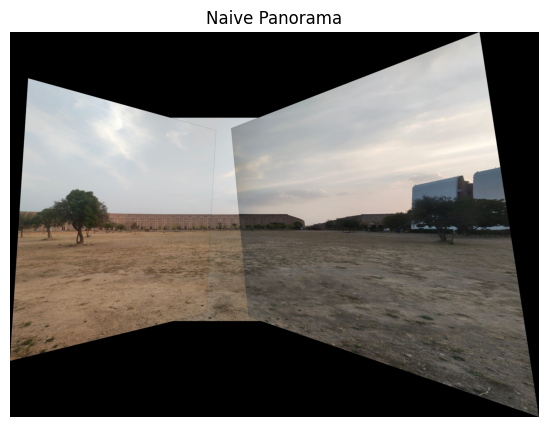

In [121]:
naive = canvas.copy()

mask_l = warp_left > 0
mask_r = warp_right > 0

naive[mask_l] = warp_left[mask_l]
naive[mask_r] = warp_right[mask_r]

plt.figure(figsize=(15,5))
plt.imshow(naive)
plt.title("Naive Panorama")
plt.axis("off")
plt.show()


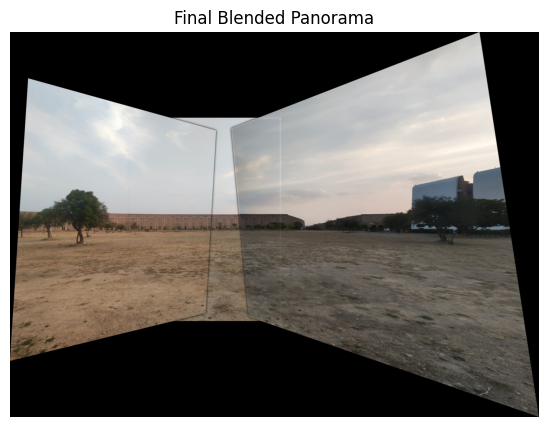

In [122]:
def smooth_blend(base, overlay):
    result = base.astype(np.float32)
    overlay = overlay.astype(np.float32)

    mask_base = np.sum(base, axis=2) > 0
    mask_overlay = np.sum(overlay, axis=2) > 0
    overlap = mask_base & mask_overlay

    result[mask_overlay & ~overlap] = overlay[mask_overlay & ~overlap]

    alpha = cv2.GaussianBlur(overlap.astype(np.float32), (51,51), 0)
    alpha = np.repeat(alpha[:,:,None], 3, axis=2)

    result = result*(1-alpha) + overlay*alpha

    return result.astype(np.uint8)

blend1 = smooth_blend(canvas, warp_left)
final_panorama = smooth_blend(blend1, warp_right)

plt.figure(figsize=(15,5))
plt.imshow(final_panorama)
plt.title("Final Blended Panorama")
plt.axis("off")
plt.show()


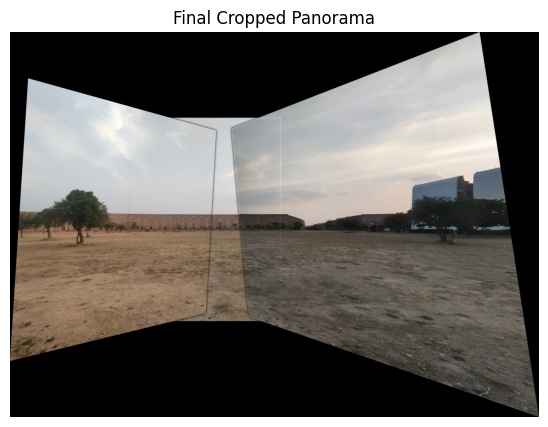

In [123]:
gray = cv2.cvtColor(final_panorama, cv2.COLOR_RGB2GRAY)
ys, xs = np.where(gray > 0)

final = final_panorama[min(ys):max(ys), min(xs):max(xs)]

plt.figure(figsize=(15,5))
plt.imshow(final)
plt.title("Final Cropped Panorama")
plt.axis("off")
plt.show()


In [124]:
def exposure_compensation(base, overlay):
    mask = (np.sum(base, axis=2) > 0) & (np.sum(overlay, axis=2) > 0)
    if np.sum(mask) == 0:
        return overlay
    
    base_mean = np.mean(base[mask])
    overlay_mean = np.mean(overlay[mask])
    
    gain = base_mean / (overlay_mean + 1e-6)
    overlay = np.clip(overlay * gain, 0, 255)
    
    return overlay.astype(np.uint8)


In [125]:
warp_left  = exposure_compensation(canvas, warp_left)
warp_right = exposure_compensation(canvas, warp_right)


In [126]:
def linear_blend(base, overlay):
    result = base.astype(np.float32)
    overlay = overlay.astype(np.float32)

    mask_base = np.sum(base, axis=2) > 0
    mask_overlay = np.sum(overlay, axis=2) > 0
    overlap = mask_base & mask_overlay

    result[mask_overlay & ~overlap] = overlay[mask_overlay & ~overlap]

    # Compute horizontal gradient in overlap
    ys, xs = np.where(overlap)
    if len(xs) > 0:
        x_min = np.min(xs)
        x_max = np.max(xs)
        width = x_max - x_min + 1
        
        for x in range(x_min, x_max + 1):
            alpha = (x - x_min) / width
            col = overlap[:, x]
            result[col, x] = (1 - alpha) * base[col, x] + alpha * overlay[col, x]

    return result.astype(np.uint8)


In [127]:
blend1 = linear_blend(canvas, warp_left)
final_panorama = linear_blend(blend1, warp_right)


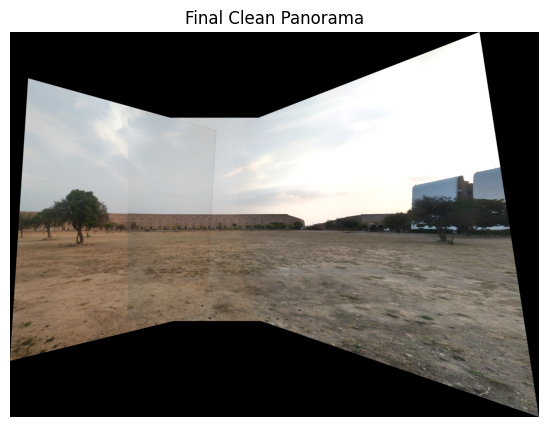

In [128]:
gray = cv2.cvtColor(final_panorama, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key=cv2.contourArea)

x, y, w, h = cv2.boundingRect(cnt)
final = final_panorama[y:y+h, x:x+w]

plt.figure(figsize=(15,5))
plt.imshow(final)
plt.title("Final Clean Panorama")
plt.axis("off")
plt.show()


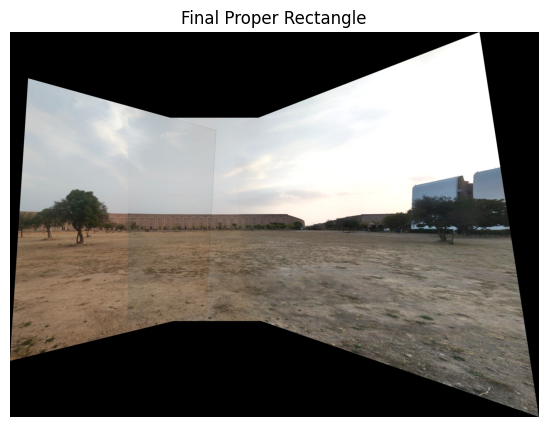

In [130]:
import cv2
import numpy as np

gray = cv2.cvtColor(final_panorama, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Largest valid area
cnt = max(contours, key=cv2.contourArea)

# Create mask of valid region
mask = np.zeros_like(gray)
cv2.drawContours(mask, [cnt], -1, 255, -1)

# Find bounding rectangle of contour
x, y, w, h = cv2.boundingRect(cnt)

# Crop safely
final = final_panorama[y:y+h, x:x+w]

plt.figure(figsize=(15,5))
plt.imshow(final)
plt.title("Final Proper Rectangle")
plt.axis("off")
plt.show()
